In [1]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mainData = pd.read_excel('Online Retail.xlsx')

In [3]:
mainData.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
mainData.dropna(inplace=True)

In [6]:
mainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [7]:
CustomerSegment=pd.read_csv('Customer Segments.csv')
Seg_dict=CustomerSegment.set_index('CustomerID').to_dict()['Labels']

In [8]:
mainData['TransactionDate'] = mainData['InvoiceDate'].apply(lambda x: f'{x.year}-{x.month}-1')
mainData['TransactionDate'] = pd.to_datetime(mainData.TransactionDate)                                                     

In [9]:
CLVData=mainData[['CustomerID','InvoiceDate','Quantity','UnitPrice']].copy()

In [10]:
CLVData['Price']=CLVData.Quantity*CLVData.UnitPrice

In [11]:
CLVData['Date']=CLVData.InvoiceDate.apply(lambda x:f'{x.year}-{x.month}-{x.day}')
CLVData['Date']=pd.to_datetime(CLVData['Date'])

In [12]:
CFirstPurchase=CLVData.sort_values(['CustomerID','Date']).groupby('CustomerID').first()

In [13]:
CFirstPurchase['Date'].min()

Timestamp('2010-12-01 00:00:00')

In [14]:
CFirstPurchase['Date'].max()

Timestamp('2011-12-09 00:00:00')

<AxesSubplot:xlabel='Date'>

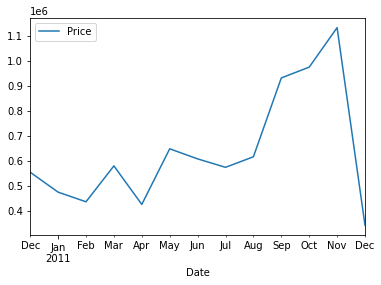

In [15]:
CLVData.set_index('Date')[['Price']].resample('MS').sum().plot()

In [16]:
CLVID_Subset=CLVData[CLVData['CustomerID'].isin(CLVData['CustomerID'].unique()[:10])].groupby(['CustomerID','Date']).sum().reset_index()

In [17]:
N_Days=90
Max_Date=CLVData['Date'].max()
CutOfDate=Max_Date-pd.to_timedelta(N_Days, unit='d')

In [18]:
CustomerOUT=CLVData[CLVData.Date>CutOfDate]
CustomerIN=CLVData[CLVData.Date<=CutOfDate]

In [19]:
Target_Customers=CustomerOUT.drop(['Quantity','InvoiceDate','UnitPrice'],axis=1).groupby('CustomerID').sum().rename({'Price':'Spend_90'},axis=1).assign(Spend_90_flag=1)

In [20]:
Max_Date=CustomerIN.Date.max()
Recency_df=CustomerIN[['CustomerID','Date']].groupby('CustomerID').apply(lambda x: (x['Date'].max()-Max_Date)/pd.to_timedelta(1,unit='day')).to_frame().set_axis(['Recency'],axis=1)
Frequency_df=CustomerIN[['CustomerID','Date']].groupby('CustomerID').count().set_axis(['Frequency'],axis=1)

In [21]:
Price_df=CustomerIN.groupby('CustomerID').aggregate({'Price':{'sum','mean'}}).set_axis(['Price_Sum','Price_Mean'],axis=1)

In [22]:
ML_Data=pd.concat([Recency_df,Frequency_df,Price_df],axis=1
).merge(Target_Customers, right_index=True,left_index=True,how='left').fillna(0)

In [23]:
ML_Data['Labels']=ML_Data.index.map(Seg_dict)

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
from xgboost import XGBRFClassifier, XGBRFRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [26]:
#Data Spliting
X=ML_Data.drop(columns=['Spend_90','Spend_90_flag'])
yr=ML_Data.Spend_90
yc=ML_Data.Spend_90_flag

In [27]:
Scaler=MinMaxScaler()

In [28]:
Scaler.fit(X)
Scaler.transform(X)

array([[1.70212766e-01, 2.18579235e-04, 5.80694049e-01, 2.35748248e-02,
        7.50000000e-01],
       [8.65248227e-01, 2.68852459e-02, 5.83742270e-01, 3.89199071e-02,
        2.50000000e-01],
       [4.43262411e-01, 5.90163934e-03, 5.87887762e-01, 3.17521681e-02,
        5.00000000e-01],
       ...,
       [8.90070922e-01, 1.53005464e-03, 5.82365991e-01, 2.41178403e-02,
        2.50000000e-01],
       [9.85815603e-01, 9.74863388e-02, 5.81033596e-01, 2.97366435e-02,
        2.50000000e-01],
       [6.09929078e-01, 6.12021858e-03, 5.84268032e-01, 2.77825903e-02,
        2.50000000e-01]])

In [30]:
SC=SVC()
SCP=dict(kernel=['rbf','sigmoid'],C=[0.5,1,1.5,2,2.5,3],
    gamma=['auto','scale',0.001,0.1])
SCGSCV=GridSearchCV(SC,
                   param_grid=SCP,cv=5,verbose=3,scoring='roc_auc',refit=True,n_jobs=-1)
SCGSCV.fit(X,yc)
print(SCGSCV.best_score_)
print(SCGSCV.best_params_)
print(SCGSCV.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.7344712252665637
{'C': 3, 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=3)


In [31]:
# SVC(C=1, gamma=1e-08)
SCData=pd.DataFrame(SCGSCV.cv_results_)
SCGSCV.score(X,yc)

0.7362300890923984

<AxesSubplot:>

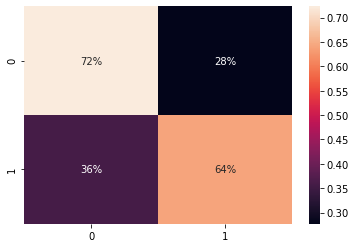

In [32]:
sns.heatmap(confusion_matrix(yc,SVC(C=3).fit(X,yc).predict(X),normalize='true'), annot=True, fmt='.0%')

In [33]:
KKC=KNeighborsClassifier(n_jobs=-1)
KKCP=dict(n_neighbors=range(5,9),
          algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'],
          p=[1,2],
          weights=['uniform', 'distance'],
          leaf_size=[20,30,40]
         )
KKCGSC=GridSearchCV(KKC,KKCP,cv=5,scoring='roc_auc',refit=True)
KKCGSC.fit(X,yc)
print(KKCGSC.best_score_)
print(KKCGSC.best_params_)
print(KKCGSC.best_estimator_)
# SVC(C=1, gamma=1e-08)
KKCData=pd.DataFrame(KKCGSC.cv_results_)
print(KKCGSC.score(X,yc))

0.7355356806627813
{'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=8, p=1,
                     weights='distance')
1.0


<AxesSubplot:>

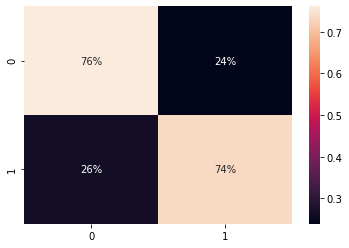

In [34]:
sns.heatmap(confusion_matrix(yc,KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=8, p=1).fit(X,yc).predict(X),normalize='true'), annot=True, fmt='.0%')

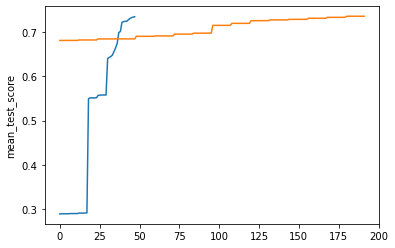

In [35]:
sns.lineplot(y=SCData.mean_test_score.sort_values(),x=SCData.index)
sns.lineplot(y=KKCData.mean_test_score.sort_values(),x=KKCData.index)
plt.show()
# #Logestic reggration
# clf = LogisticRegression(random_state=0).fit(X, y)

In [36]:
LC=LogisticRegression(random_state=0)
LCP=dict(penalty=['l2','l1'],
    C=[0.01,0.001,0.0001],
    class_weight=[None,'balanced'],
    solver=['liblinear'],
         multi_class=['ovr','auto'],
    max_iter=[100,200])
LCGSC=GridSearchCV(LC,LCP,cv=5,scoring='roc_auc',refit=True,n_jobs=-1)
LCGSC.fit(X,yc)
print(LCGSC.best_score_)
print(LCGSC.best_params_)
print(LCGSC.best_estimator_)
# SVC(C=1, gamma=1e-08)
LCData=pd.DataFrame(LCGSC.cv_results_)
print(LCGSC.score(X,yc))

0.8054795470638834
{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=0.01, class_weight='balanced', multi_class='ovr',
                   random_state=0, solver='liblinear')
0.8064200339172132


<AxesSubplot:>

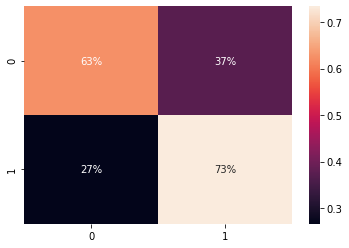

In [37]:
sns.heatmap(confusion_matrix(yc,LogisticRegression(C=0.001, multi_class='ovr', penalty='l1', random_state=0,
                   solver='liblinear').fit(X,yc).predict(X),normalize='true'), annot=True, fmt='.0%')

In [38]:
DC=DecisionTreeClassifier(random_state=0)
DCP=dict(
criterion=['gini', 'entropy'],
splitter=['best'],
max_depth=[None,1,2,3,4],
min_samples_split=range(2,6),
min_samples_leaf=range(1,6),

max_features=['auto', 'sqrt', 'log2'],

max_leaf_nodes=[2,3,4,5,6,7,8],
min_impurity_decrease=[0.1,0.001],
    


)

DCGSC=GridSearchCV(DC,DCP,cv=10,scoring='roc_auc',refit=True,n_jobs=-1)
DCGSC.fit(X,yc)
print(DCGSC.best_score_)
print(DCGSC.best_params_)
print(DCGSC.best_estimator_)
# SVC(C=1, gamma=1e-08)
DCData=pd.DataFrame(DCGSC.cv_results_)
print(DCGSC.score(X,yc))

0.9975283617680203
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 5, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
DecisionTreeClassifier(max_features='auto', max_leaf_nodes=5,
                       min_impurity_decrease=0.001, random_state=0)
0.9975499941691618


<AxesSubplot:>

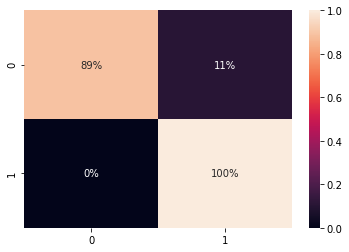

In [39]:
sns.heatmap(confusion_matrix(yc,DecisionTreeClassifier(max_depth=3, max_features='auto', max_leaf_nodes=8,
                        random_state=0).fit(X,yc).predict(X),normalize='true'), annot=True, fmt='.0%')

In [40]:
RC=RandomForestClassifier(n_jobs=-1)
RCP=dict(n_estimators=[300,400],
    criterion=['gini','entropy'],
    max_depth=[4,5,6,7,8,9],
    min_samples_split=[2,3,4],
    min_samples_leaf=[1],
    
    max_features=['auto'],
    max_leaf_nodes=[2,3],
    )
RCGSCV=GridSearchCV(RC,RCP,cv=10,scoring='roc_auc',refit=True,verbose=3,n_jobs=-1)
RCGSCV.fit(X,yc)
print(RCGSCV.best_score_)
print(RCGSCV.best_params_)
print(RCGSCV.best_estimator_)
# SVC(C=1, gamma=1e-08)
RCData=pd.DataFrame(RCGSCV.cv_results_)
print(RCGSCV.score(X,yc))

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
0.9501896921880558
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 3, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
RandomForestClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=3,
                       min_samples_split=4, n_estimators=400, n_jobs=-1)
0.9520273051832641


<AxesSubplot:>

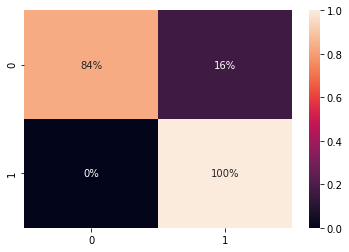

In [41]:
sns.heatmap(confusion_matrix(yc,RandomForestClassifier(max_depth=9, max_leaf_nodes=3, n_estimators=300,
                       n_jobs=-1).fit(X,yc).predict(X),normalize='true'), annot=True, fmt='.0%')

In [42]:
ABC=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, max_features='auto', max_leaf_nodes=8,
                       min_impurity_decrease=0.001, random_state=0))
ABCP=dict(n_estimators=[200],
         learning_rate=[0.01,0.001,0.00001],
         )

ABCGSCV=GridSearchCV(ABC,ABCP,cv=10,scoring='roc_auc',refit=True,n_jobs=-1)
ABCGSCV.fit(X,yc)
print(ABCGSCV.best_score_)
print(ABCGSCV.best_params_)
print(ABCGSCV.best_estimator_)
# SVC(C=1, gamma=1e-08)
ABCData=pd.DataFrame(ABCGSCV.cv_results_)
print(ABCGSCV.score(X,yc))

0.9980484435880379
{'learning_rate': 1e-05, 'n_estimators': 200}
AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         max_features='auto',
                                                         max_leaf_nodes=8,
                                                         min_impurity_decrease=0.001,
                                                         random_state=0),
                   learning_rate=1e-05, n_estimators=200)
0.9981994652489066


<AxesSubplot:>

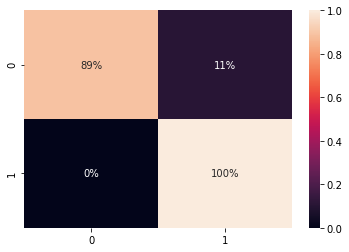

In [43]:
sns.heatmap(confusion_matrix(yc,AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         max_features='auto',
                                                         max_leaf_nodes=8,
                                                         min_impurity_decrease=0.001,
                                                         random_state=0),
                   learning_rate=0.001, n_estimators=200).fit(X,yc).predict(X),normalize='true'), annot=True, fmt='.0%')

In [ ]:
# ABC=AdaBoostClassifier(base_estimator=SVC(C=3,probability=True),random_state=0)
# ABCP=dict(n_estimators=[50],
#          learning_rate=[0.01,0.05],
#          )

# ABCGSCV=GridSearchCV(ABC,ABCP,cv=10,scoring='roc_auc',refit=True,n_jobs=-1)
# ABCGSCV.fit(X,yc)
# print(ABCGSCV.best_score_)
# print(ABCGSCV.best_params_)
# print(ABCGSCV.best_estimator_)
# # SVC(C=1, gamma=1e-08)
# ABCData=pd.DataFrame(ABCGSCV.cv_results_)
# print(ABCGSCV.score(X,yc))

In [45]:
ML_Data['KNN_Predict_Prob']=KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=8, p=1).fit(X,yc).predict_proba(X)[:,1]
ML_Data['SVC_Predict_Prob']=SVC(C=3,probability=True).fit(X,yc).predict_proba(X)[:,1]
ML_Data['AB_Predict_Prob']=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         max_features='auto',
                                                         max_leaf_nodes=8,
                                                         min_impurity_decrease=0.001,
                                                         random_state=0),
                   learning_rate=1e-05, n_estimators=200).fit(X,yc).predict_proba(X)[:,1]
ML_Data['RF_Predict_Prob']=RandomForestClassifier(criterion='entropy', max_depth=5, max_leaf_nodes=3,
                       min_samples_split=4, n_estimators=400, n_jobs=-1).fit(X,yc).predict_proba(X)[:,1]
ML_Data['DT_Predict_Prob']=DecisionTreeClassifier(max_features='auto', max_leaf_nodes=5,
                       min_impurity_decrease=0.001, random_state=0).fit(X,yc).predict_proba(X)[:,1]
ML_Data['DT_Predict_Prob']=LogisticRegression(C=0.01, class_weight='balanced', multi_class='ovr',
                   random_state=0, solver='liblinear').fit(X,yc).predict_proba(X)[:,1]

In [46]:
ML_Data.to_csv('ClassifiactionProb.csv',index=False)